In [1]:
# misc
import warnings
warnings.filterwarnings('ignore')
import gc

# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='colorblind')

# processing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import gmean
from scipy.sparse import csr_matrix

import shap

# models
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.linear_model import LinearRegression, Ridge

In [2]:
# This will be now a dataframe
def stats_prop(df, usefractions=False):
    means = []
    gmeans = []
    medians = []
    stds = []
    skews = []
    kurts = []
    mins = []
    maxs = []
    sums = []
    counts = []
    fractions = []
    q1s = []
    q3s = []
    log_means = []
    log_gmeans = []
    log_medians = []
    log_stds = []
    log_skews = []
    log_kurts = []
    log_mins = []
    log_maxs = []
    log_q1s = []
    log_q3s = []
       
    for i, row in df.iterrows():
        nonzero_values = row[row.nonzero()[0]]
        if usefractions:
            nonzero_values = nonzero_values[nonzero_values-nonzero_values//1 != 0.]
        means.append(nonzero_values.mean())
        gmeans.append(gmean(nonzero_values))
        medians.append(nonzero_values.median())
        stds.append(nonzero_values.std())
        skews.append(nonzero_values.skew())
        kurts.append(nonzero_values.kurtosis())
        mins.append(nonzero_values.min())
        maxs.append(nonzero_values.max())
        sums.append(nonzero_values.sum())
        counts.append(nonzero_values.count())
        fractions.append(nonzero_values.count()/row.count())        
        q1s.append(np.percentile(nonzero_values, q=25) if len(nonzero_values)>0 else np.nan)
        q3s.append(np.percentile(nonzero_values, q=75) if len(nonzero_values)>0 else np.nan)
        log_means.append(np.log1p(nonzero_values).mean())
        log_gmeans.append(gmean(np.log1p(nonzero_values)))
        log_medians.append(np.log1p(nonzero_values).median())
        log_stds.append(np.log1p(nonzero_values).std())
        log_skews.append(np.log1p(nonzero_values).skew())
        log_kurts.append(np.log1p(nonzero_values).kurtosis())
        log_mins.append(np.log1p(nonzero_values).min())
        log_maxs.append(np.log1p(nonzero_values).max())
        log_q1s.append(np.percentile(np.log1p(nonzero_values), q=25) if len(nonzero_values)>0 else np.nan)
        log_q3s.append(np.percentile(np.log1p(nonzero_values), q=25) if len(nonzero_values)>0 else np.nan)
    
    stat_df = pd.DataFrame({'means': np.array(means)})
    stat_df['gmeans'] = np.array(gmeans)
    stat_df['medians'] = np.array(medians)
    #stat_df['stds'] = np.array(stds)
    #stat_df['skews'] = np.array(skews)
    #stat_df['kurts'] = np.array(kurts)
    stat_df['mins'] = np.array(mins)
    stat_df['maxs'] = np.array(maxs)
    stat_df['sums'] = np.array(sums)
    stat_df['counts'] = np.array(counts)
    stat_df['fractions'] = np.array(fractions)
    stat_df['q1s'] = np.array(q1s)
    stat_df['q3s'] = np.array(q3s)
    stat_df['log_means'] = np.array(log_means)
    #stat_df = pd.DataFrame({'log_means': np.array(log_means)})
    stat_df['log_gmeans'] = np.array(log_gmeans)
    stat_df['log_medians'] = np.array(log_medians)
    #stat_df['log_stds'] = np.array(log_stds)
    #stat_df['log_skews'] = np.array(log_skews)
    #stat_df['log_kurts'] = np.array(log_kurts)
    stat_df['log_mins'] = np.array(log_mins)
    stat_df['log_maxs'] = np.array(log_maxs)
    stat_df['log_q1s'] = np.array(log_q1s)
    stat_df['log_q3s'] = np.array(log_q3s)
    
    return stat_df    

In [3]:
def other_derived(df):
    total_cols = df.shape[1]
    #first_nonzeros = []
    first_nonzero_values = []
    #first_nonzero_weights = []
    #last_nonzeros = []
    last_nonzero_values = []
    #last_nonzero_weights = []
    #means_dif_x = []
    #stds_dif_x = []
    means_dif_y = []
    stds_dif_y = []
    log_means_dif_y = []
    log_stds_dif_y = []
    weighted_direct = []
    weighted_inverse = []
    
    for i, row in df.iterrows():
        nonzero_idxs = row.nonzero()[0]
        nonzero_values = row[row.nonzero()[0]]
        #first_nonzeros.append(nonzero_idxs[0] if len(nonzero_idxs)>0 else np.nan)
        #last_nonzeros.append(nonzero_idxs[-1] if len(nonzero_idxs)>0 else np.nan)
        first_nonzero_values.append(nonzero_values[0] if len(nonzero_idxs)>0 else np.nan)
        last_nonzero_values.append(nonzero_values[-1] if len(nonzero_idxs)>0 else np.nan)
        #first_nonzero_weights.append(nonzero_values[0]*nonzero_idxs[0] if len(nonzero_idxs)>0 else np.nan)
        #last_nonzero_weights.append(nonzero_values[-1]*nonzero_idxs[-1] if len(nonzero_idxs)>0 else np.nan)
        if len(nonzero_idxs)>0:
            x = []
            y = []
            xyup = 0.
            xydown = 0.
            for xx, yy in zip(nonzero_idxs, nonzero_values):
                xyup += (xx+1)*yy
                xydown += yy/(xx+1)
                if len(x)==0:
                    x.append(xx)
                    xold = xx
                else:
                    x.append(xx-xold)
                    xold = xx
                if len(y)==0:
                    y.append(yy)
                    yold = yy
                else:
                    y.append(np.abs(yy-yold))
                    yold = yy
            #means_dif_x.append(np.array(x).mean())
            #stds_dif_x.append(np.array(x).std())
            means_dif_y.append(np.array(y).mean())
            stds_dif_y.append(np.array(y).std())
            log_means_dif_y.append(np.log1p(np.array(y)).mean())
            log_stds_dif_y.append(np.log1p(np.array(y)).std())
            weighted_direct.append(xyup)
            weighted_inverse.append(xydown)
        else:
            #means_dif_x.append(np.nan)
            #stds_dif_x.append(np.nan)
            means_dif_y.append(np.nan)
            stds_dif_y.append(np.nan)
            log_means_dif_y.append(np.nan)
            log_stds_dif_y.append(np.nan)
            weighted_direct.append(np.nan)
            weighted_inverse.append(np.nan)
    
    #other_df = pd.DataFrame({'means delta x': np.array(means_dif_x)})
    #other_df['stds delta x'] = np.array(stds_dif_x)
    #other_df['means delta y'] = np.array(means_dif_y)
    #other_df = pd.DataFrame({'means delta y': np.array(means_dif_y)})
    #other_df['stds delta y'] = np.array(stds_dif_y)
    #other_df['log means delta y'] = np.array(log_means_dif_y)
    #other_df['log stds delta y'] = np.array(log_stds_dif_y)
    #other_df['nonzero weighted'] = np.array(weighted_direct)
    #other_df['nonzero weighted inverse'] = np.array(weighted_inverse)
    #other_df['first nonzero'] = np.array(first_nonzeros)
    #other_df['last nonzero'] = np.array(last_nonzeros)
    #other_df['first nonzero value'] = np.array(first_nonzero_values)
    other_df = pd.DataFrame({'first nonzero value': np.array(first_nonzero_values)})
    other_df['last nonzero value'] = np.array(last_nonzero_values)
    #other_df['first nonzero weighted'] = np.array(first_nonzero_weights)
    #other_df['last nonzero weighted'] = np.array(last_nonzero_weights)
    
    return other_df   

In [4]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

In [5]:
target = train_data.target
train_ID = train_data.ID
train_data = train_data.drop(['target', 'ID'], axis=1)
test_ID = test_data.ID
test_data = test_data.drop(['ID'], axis=1)

In [6]:
vt = VarianceThreshold(threshold=0.)
vt.fit(train_data)
selected_columns = train_data.columns[vt.get_support(indices=True)]

In [7]:
train_data = train_data[selected_columns]
test_data = test_data[selected_columns]

train_data.shape

(4459, 4735)

In [8]:
train_data = train_data.T.drop_duplicates().T
test_data = test_data[train_data.columns]

train_data.shape

(4459, 4730)

In [9]:
train_data = train_data/1000.
test_data = test_data/1000.

In [10]:
log_target = np.log1p(target/1000.)

In [11]:
train_data = train_data.replace(0., np.nan)
test_data = test_data.replace(0., np.nan)

In [12]:
train_leak = pd.read_csv('../submission_files/leak/train_leak.csv', usecols=['compiled_leak']).replace(np.nan, 0.)
test_leak = pd.read_csv('../submission_files/leak/test_leak.csv', usecols=['compiled_leak']).replace(np.nan, 0.)

In [13]:
leak_index_train = train_leak[train_leak.compiled_leak != 0.].index.values
leak_index_test = test_leak[test_leak.compiled_leak != 0.].index.values

In [47]:
noleak_index_train = train_leak[train_leak.compiled_leak == 0.].index.values

In [14]:
leak_values_train = train_leak.compiled_leak[leak_index_train].values
leak_values_test = test_leak.compiled_leak[leak_index_test].values

In [15]:
cols_leak = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010',
             '024c577b9', 'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', '62e59a501', '2ec5b290f', '241f0f867',
             'fb49e4212', '66ace2992', 'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', '703885424', '70feb1494',
             '491b9ee45', '23310aa6f', 'e176a204a', '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2', '190db8488',
             'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98']

In [16]:
# CV folds
kf = KFold(n_splits=10, shuffle=True)
n_splits = kf.get_n_splits()

In [17]:
# model parameters
params = {'learning_rate':0.5, 'metric':'rmse', 'max_bin':63, 'device':'cpu'}

In [18]:
shap_values = np.zeros((train_data.shape[0],train_data.shape[1]+1))

for train_index, test_index in kf.split(train_data):
    
    X_tr, X_tst = train_data.values[train_index], train_data.values[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]
    
    train_set = lgb.Dataset(X_tr, label=y_tr)
    valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
    bst = lgb.train(params, train_set, num_boost_round=50, valid_sets=[train_set, valid_set], early_stopping_rounds=5,
                    verbose_eval=False)

    shap_values += shap.TreeExplainer(bst).shap_values(train_data.values)/n_splits

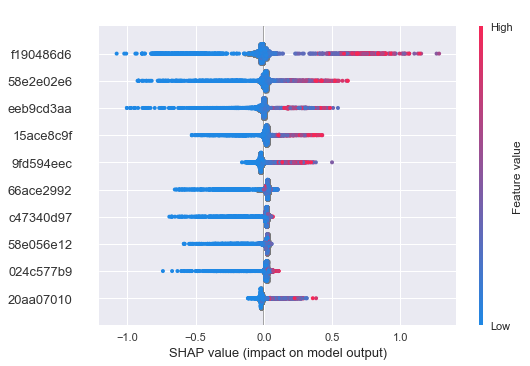

In [19]:
shap.summary_plot(shap_values, train_data, max_display=10, plot_type='dot')

In [20]:
N = 150
sorted_columns = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])[::-1]
most_relevant = train_data.columns[sorted_columns[:N]]

In [21]:
union_cols = list(set(most_relevant)|set(cols_leak))
diff_cols = list(set(most_relevant)-set(cols_leak))

In [22]:
feat_train = train_data[union_cols]
feat_test = test_data[union_cols]

In [23]:
feat_train = feat_train[feat_train.isna().sum().sort_values().index.values]
feat_test = feat_test[feat_train.isna().sum().sort_values().index.values]

In [24]:
stat_train = stats_prop(train_data)
stat_test = stats_prop(test_data)

#### Assembly

In [67]:
feat_train.iloc[noleak_index_train].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [68]:
train_final = np.hstack((feat_train.iloc[noleak_index_train].values, stat_train.iloc[noleak_index_train].values))
test_final = np.hstack((feat_test.values, stat_test.values))

In [69]:
len(union_cols)

152

In [70]:
print('Final number of features: %i' % train_final.shape[0])

Final number of features: 826


In [71]:
# model parameters
params = {'boosting': 'gbdt', 'objective':'regression', 'learning_rate':0.002, 'metric':'rmse', 'max_bin':63, 
          'lambda_l2': 0.1, 'device':'cpu', 'feature_fraction': 0.1, 'lambda_l1': 0.002}

In [72]:
def crossval():
    kf = KFold(n_splits=5, shuffle=True)
    n_splits = kf.get_n_splits()
    preds = np.zeros(test_ID.shape[0])
    for train_index, test_index in kf.split(train_final):
        X_tr, X_tst = train_final[train_index], train_final[test_index]
        y_tr, y_tst = log_target[train_index], log_target[test_index]

        train_set = lgb.Dataset(X_tr, label=y_tr)
        valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)

        bst = lgb.train(params, train_set, num_boost_round=7500, valid_sets=[train_set, valid_set], early_stopping_rounds=500, 
                        verbose_eval=1000)

        y_val = bst.predict(X_tst, num_iteration=bst.best_iteration)

        rmsle = np.sqrt(mean_squared_error(y_tst, y_val))

        preds = preds + np.expm1(bst.predict(test_final, num_iteration=bst.best_iteration))/n_splits
        
    return preds

In [73]:
def bag(nbag=10):
    submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_ID.shape[0])})
    for i in range(nbag):
        new_preds = crossval()
        submission.target = submission.target + new_preds/nbag
    return submission

In [74]:
submission = bag()

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.72901	valid_1's rmse: 1.56859
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.66992	valid_1's rmse: 1.80437
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 1.53714	valid_1's rmse: 1.66059
Early stopping, best iteration is:
[1427]	training's rmse: 1.48271	valid_1's rmse: 1.65729
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.69389	valid_1's rmse: 1.71308
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[256]	training's rmse: 1.63957	valid_1's rmse: 1.71092
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[241]	training's rmse: 1.66131	valid_1's rmse: 1.63919
Training until validation score

Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 1.5385	valid_1's rmse: 1.63357
Early stopping, best iteration is:
[737]	training's rmse: 1.57798	valid_1's rmse: 1.63233
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	training's rmse: 1.69764	valid_1's rmse: 1.69698


In [75]:
submission.head(11)

,ID,target
0,000137c73,2009.601117
1,00021489f,2172.466581
2,0004d7953,2351.595505
3,00056a333,2304.497594
4,00056d8eb,2178.511275
5,0005fc190,2111.024294
6,000787e86,2272.794791
7,0008510a0,2201.577990
8,000895faf,2096.909786
9,000986fba,2371.374519


In [76]:
submission.target = 1000*np.ceil(submission.target)

In [78]:
submission.head(44)

,ID,target
0,000137c73,2010000.0
1,00021489f,2173000.0
2,0004d7953,2352000.0
3,00056a333,2305000.0
4,00056d8eb,2179000.0
5,0005fc190,2112000.0
6,000787e86,2273000.0
7,0008510a0,2202000.0
8,000895faf,2097000.0
9,000986fba,2372000.0


In [40]:
submission.to_csv('../submission_files/leak/onlylgb_unionf.csv', index=False)

In [79]:
sub = submission.copy()

In [80]:
sub.target[leak_index_test] = leak_values_test

In [82]:
sub.head(44)

,ID,target
0,000137c73,2010000.0
1,00021489f,2173000.0
2,0004d7953,2352000.0
3,00056a333,2305000.0
4,00056d8eb,2179000.0
5,0005fc190,2112000.0
6,000787e86,2273000.0
7,0008510a0,2202000.0
8,000895faf,2097000.0
9,000986fba,2372000.0


In [83]:
sub.to_csv('../submission_files/leak/onlylgb+leak_unionf_trainnoleak.csv', index=False)